In [ ]:
### Ini gabungan dari library yang diapke buat coba coba (jadi gasepenuhnya dipake, ada juga yang disebut lagi di bawah) -- maklum namnanya coba coba

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score




In [47]:
# Load data
X = pd.read_csv("../data/processed/X_scaled.csv", dtype='float32')
y = pd.read_csv("../data/processed/y.csv", dtype='int8').squeeze()
X.info()
y.value_counts(normalize=True)


# Load selected features
#with open("../data/processed/selected_features.json") as f:
#    selected_features = json.load(f)

# Ambil kolom fitur terpilih
#X_selected = X[selected_features]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768674 entries, 0 to 2768673
Data columns (total 78 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination_Port             float32
 1   Flow_Duration                float32
 2   Total_Fwd_Packets            float32
 3   Total_Backward_Packets       float32
 4   Total_Length_of_Fwd_Packets  float32
 5   Total_Length_of_Bwd_Packets  float32
 6   Fwd_Packet_Length_Max        float32
 7   Fwd_Packet_Length_Min        float32
 8   Fwd_Packet_Length_Mean       float32
 9   Fwd_Packet_Length_Std        float32
 10  Bwd_Packet_Length_Max        float32
 11  Bwd_Packet_Length_Min        float32
 12  Bwd_Packet_Length_Mean       float32
 13  Bwd_Packet_Length_Std        float32
 14  Flow_Bytes_s                 float32
 15  Flow_Packets_s               float32
 16  Flow_IAT_Mean                float32
 17  Flow_IAT_Std                 float32
 18  Flow_IAT_Max                 float32
 19  

Label
1    0.810092
0    0.189908
Name: proportion, dtype: float64

In [50]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.01)
X_var = sel.fit_transform(X)

# ambil kolom yang lolos threshold
selected_features = X.columns[sel.get_support()]
removed_features = X.columns[~sel.get_support()]

print("\n=== FITUR YANG DIPERTAHANKAN ===")
print(selected_features.tolist())

print("\n=== FITUR YANG DIHAPUS (VARIANS < 0.01) ===")
print(removed_features.tolist())

print(f"\nJumlah fitur awal: {X.shape[1]}")
print(f"Jumlah fitur akhir: {X_var.shape[1]}")



=== FITUR YANG DIPERTAHANKAN ===
['Destination_Port', 'Flow_Duration', 'Total_Fwd_Packets', 'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets', 'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max', 'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean', 'Bwd_Packet_Length_Std', 'Flow_Bytes_s', 'Flow_Packets_s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Fwd_Header_Length', 'Bwd_Header_Length', 'Fwd_Packets_s', 'Bwd_Packets_s', 'Min_Packet_Length', 'Max_Packet_Length', 'Packet_Length_Mean', 'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag_Count', 'SYN_Flag_Count', 'PSH_Flag_Count', 'ACK_Flag_Count', 'URG_Flag_Count', 'Down_Up_Ratio', 'Average_Packet_Size', 'Avg_Fwd_Segment_Size', 'Avg

In [71]:
# === Ubah hasil VarianceThreshold ke DataFrame baru untuk korelasi ===
X_var_df = pd.DataFrame(X_var, columns=selected_features)

# === Cek korelasi antar fitur dan buang yang > 0.95 ===
corr = X_var_df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Buang fitur yang sangat berkorelasi
X_filtered = X_var_df.drop(columns=to_drop)

print("\n=== FITUR YANG DIHAPUS KARENA KORELASI TINGGI ===")
print(to_drop)
print(f"\nJumlah fitur akhir setelah korelasi filter: {X_filtered.shape[1]}")


=== FITUR YANG DIHAPUS KARENA KORELASI TINGGI ===
['Total_Backward_Packets', 'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Mean', 'Bwd_Packet_Length_Std', 'Fwd_IAT_Total', 'Fwd_IAT_Max', 'Fwd_Packets_s', 'Packet_Length_Std', 'SYN_Flag_Count', 'Average_Packet_Size', 'Avg_Fwd_Segment_Size', 'Avg_Bwd_Segment_Size', 'Fwd_Header_Length.1', 'Subflow_Fwd_Packets', 'Subflow_Fwd_Bytes', 'Subflow_Bwd_Packets', 'Subflow_Bwd_Bytes', 'Idle_Mean', 'Idle_Max', 'Idle_Min']

Jumlah fitur akhir setelah korelasi filter: 45


In [74]:
attack_count = (y == 0).sum()
benign_count = (y == 1).sum()
print(f"\nAttack: {attack_count}, Benign: {benign_count}")


Attack: 525794, Benign: 2242880


In [75]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42, stratify=y)

# Train hanya pada benign (0)
X_train_benign = X_train[y_train == 0]

print("Data train:", X_train_benign.shape)
print("Data test :", X_test.shape)

Data train: (420635, 45)
Data test : (553735, 45)


In [76]:
# Model
iso = IsolationForest(
    n_estimators=300,
    max_samples=1.0,
    contamination=0.2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train_benign)

# Prediksi
y_pred = iso.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)  # -1 → attack, 1 → benign

In [77]:
# Evaluasi
print("=== HASIL MODEL DENGAN 45 FITUR (SETELAH CORR FILTER) ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

print(f"F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | ROC AUC: {roc:.4f}")

=== HASIL MODEL DENGAN 45 FITUR (SETELAH CORR FILTER) ===
[[ 84022  21137]
 [ 14844 433732]]
              precision    recall  f1-score   support

           0       0.85      0.80      0.82    105159
           1       0.95      0.97      0.96    448576

    accuracy                           0.94    553735
   macro avg       0.90      0.88      0.89    553735
weighted avg       0.93      0.94      0.93    553735

F1: 0.9602 | Precision: 0.9535 | Recall: 0.9669 | ROC AUC: 0.8830


In [81]:
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Overlap:", np.intersect1d(X_train.index, X_test.index).size)


Train size: (2214939, 45) Test size: (553735, 45)
Overlap: 0


In [85]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


[[ 84022  21137]
 [ 14844 433732]]
              precision    recall  f1-score   support

           0       0.85      0.80      0.82    105159
           1       0.95      0.97      0.96    448576

    accuracy                           0.94    553735
   macro avg       0.90      0.88      0.89    553735
weighted avg       0.93      0.94      0.93    553735

ROC AUC: 0.8829541138030023


=== CONFUSION MATRIX ===
[[ 84022  21137]
 [ 14844 433732]]

Detail Nilai:
TP (True Positive)  : 433732
FP (False Positive) : 21137
FN (False Negative) : 14844
TN (True Negative)  : 84022

=== METRIK PERFORMA ===
F1-score   : 0.9602
Precision  : 0.9535
Recall     : 0.9669
ROC AUC    : 0.8830


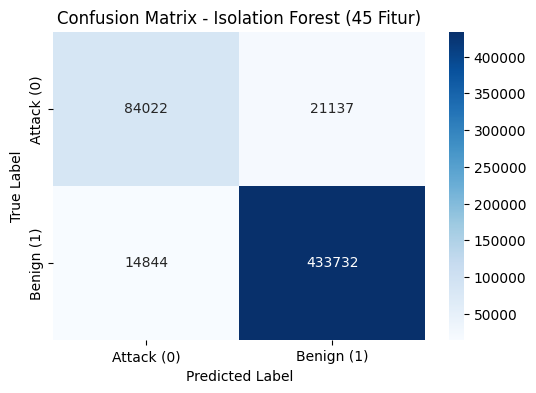

In [91]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score

# Asumsi y_test dan y_pred sudah ada
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("=== CONFUSION MATRIX ===")
print(cm)

print("\nDetail Nilai:")
print(f"TP (True Positive)  : {tp}")
print(f"FP (False Positive) : {fp}")
print(f"FN (False Negative) : {fn}")
print(f"TN (True Negative)  : {tn}")

# Evaluasi lengkap
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

print("\n=== METRIK PERFORMA ===")
print(f"F1-score   : {f1:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"ROC AUC    : {roc:.4f}")

# Visualisasi confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack (0)", "Benign (1)"], yticklabels=["Attack (0)", "Benign (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Isolation Forest (45 Fitur)")
plt.show()


Attack mean: -0.4762
Benign mean: -0.3635
Attack std : 0.0683
Benign std : 0.0343


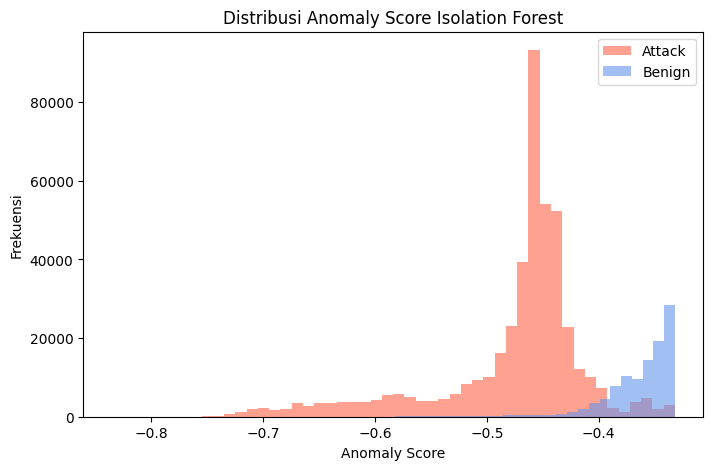

In [106]:
# Hitung anomaly score
scores = iso.score_samples(X_test)

# Pisahkan berdasarkan label asli (misal y_test)
scores_attack = scores[y_test == 1]  # sesuaikan label attack = 1
scores_benign = scores[y_test == 0]  # label benign = 0

# Statistik
print(f"Attack mean: {scores_attack.mean():.4f}")
print(f"Benign mean: {scores_benign.mean():.4f}")
print(f"Attack std : {scores_attack.std():.4f}")
print(f"Benign std : {scores_benign.std():.4f}")

# Visualisasi
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(scores_attack, bins=50, color='tomato', alpha=0.6, label='Attack')
plt.hist(scores_benign, bins=50, color='cornflowerblue', alpha=0.6, label='Benign')
plt.title("Distribusi Anomaly Score Isolation Forest")
plt.xlabel("Anomaly Score")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()


In [107]:
from sklearn.metrics import adjusted_rand_score

model1 = IsolationForest(random_state=42).fit(X)
model2 = IsolationForest(random_state=99).fit(X)
y1 = model1.predict(X)
y2 = model2.predict(X)

ari = adjusted_rand_score(y1, y2)
print("Adjusted Rand Index:", ari)


Adjusted Rand Index: 0.8581228876346514


## Validasi Kemampuan IsoForest
### Konsep utama

#### Isolation Forest hanya dilatih pada data normal (benign).
#### Saat diberikan data baru:

- Data yang mirip dengan training → skor tinggi → dianggap normal

- Data yang berbeda signifikan → skor rendah → dianggap anomaly

#### Ini artinya: model generalisasi ke data baru, selama distribusi anomali berbeda dari data normal.

In [108]:
# ===== DATA BENIGN (normal) =====
np.random.seed(42)
X_train_benign = np.random.normal(0, 1, size=(200, 2))  # data 2D normal

In [110]:
# ===== DATA BARU =====
X_test_benign = np.random.normal(0, 1, size=(50, 2))     # data normal baru
X_test_attack = np.random.normal(5, 1, size=(50, 2))     # data anomali baru

X_test = np.vstack([X_test_benign, X_test_attack])
y_test = np.array([0]*50 + [1]*50)  # 0=benign, 1=attack

In [111]:
# ===== ISOLATION FOREST =====
iso = IsolationForest(contamination=0.2, random_state=42)
iso.fit(X_train_benign)  # hanya belajar data normal

scores = iso.score_samples(X_test)

In [112]:
# ===== Statistik =====
scores_benign = scores[y_test==0]
scores_attack = scores[y_test==1]

print(f"Benign mean: {scores_benign.mean():.4f}, std: {scores_benign.std():.4f}")
print(f"Attack mean: {scores_attack.mean():.4f}, std: {scores_attack.std():.4f}")

Benign mean: -0.4781, std: 0.0742
Attack mean: -0.7526, std: 0.0158


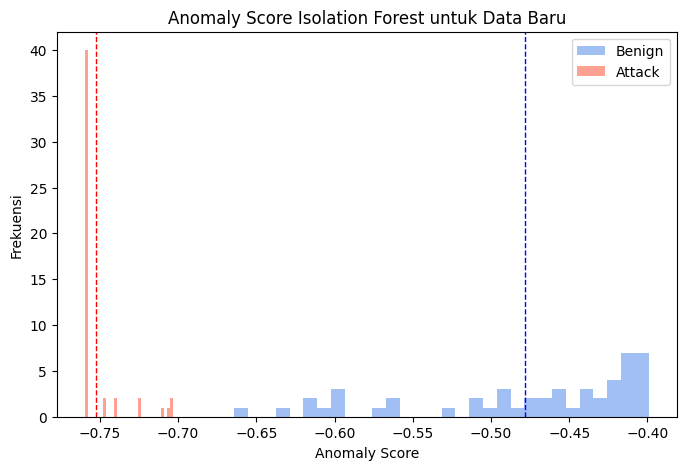

In [113]:
# ===== Visualisasi =====
plt.figure(figsize=(8,5))
plt.hist(scores_benign, bins=30, color='cornflowerblue', alpha=0.6, label='Benign')
plt.hist(scores_attack, bins=30, color='tomato', alpha=0.6, label='Attack')
plt.axvline(scores_benign.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(scores_attack.mean(), color='red', linestyle='dashed', linewidth=1)
plt.title("Anomaly Score Isolation Forest untuk Data Baru")
plt.xlabel("Anomaly Score")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()